**DASH APP**

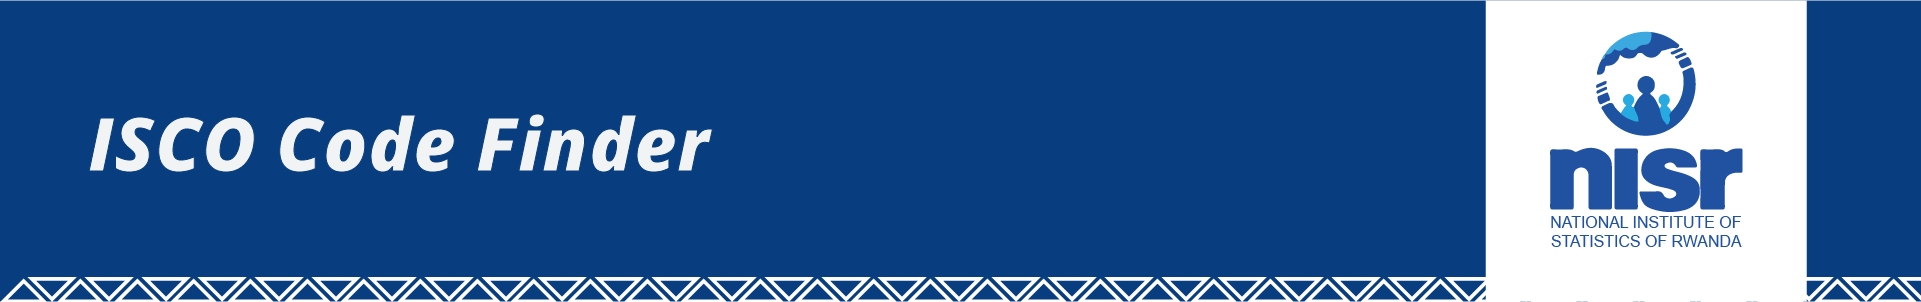

<IPython.core.display.Javascript object>

In [8]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import openai
client = openai
from dash import Dash, dcc, html, Input, Output, State
from IPython.display import Image, display

# Accessing the openai api_key
client.api_key = "API_Key"

# --------------------- #
#   DISPLAY IMAGE IN NOTEBOOK
# --------------------- #

image_path = "/content/PNG_IN_NOTEBOOK_NISR_02_1.png"
display(Image(filename=image_path))

# --------------------- #
#   LOAD DATASET
# --------------------- #

df = pd.read_pickle("/content/isco_08_df_with_embeddings.pkl")

# --------------------- #
#   FUNCTION: Generate Text Embeddings
# --------------------- #

def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    response = openai.Embedding.create(input=text, model=model)
    return response['data'][0]['embedding']

# --------------------- #
#   FUNCTION: Calculate Similarity Score
# --------------------- #

def calculate_similarity(query_embedding, db_embeddings):
    similarities = np.dot(db_embeddings, query_embedding)
    return similarities

# --------------------- #
#   FUNCTION: Retrieve Top 4 Matching Rows
# --------------------- #

def query_system(question, df, model="text-embedding-ada-002"):
    query_embedding = get_embedding(question, model=model)

    # Convert stored embeddings into a matrix
    db_embeddings = np.vstack(df['embeddings'])
    similarities = calculate_similarity(query_embedding, db_embeddings)

    # Get indices of top 4 most similar rows
    top_4_indices = np.argsort(similarities)[-4:][::-1]
    retrieved_rows = df.iloc[top_4_indices]

    return retrieved_rows

# --------------------- #
#   FUNCTION: Generate Response using GPT-3.5 Turbo
# --------------------- #

def generate_response(question, retrieved_rows):
    combined_context = "\n\n".join(retrieved_rows['detailed_explanation'].dropna())

    # Return default message if no relevant context is found
    if not combined_context.strip():
        return "No such code for the occupation."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a helpful assistant trained to classify job descriptions and provide occupation codes based on context. "
                    "Always respond with: 'The occupational code is: [code] for [occupation description].' "
                    "If the context does not match the query, respond with: 'No such code for the occupation.'"
                ),
            },
            {
                "role": "user",
                "content": f"Based on these contexts:\n\n{combined_context}\n\nAnswer the query: {question}"
            }
        ]
    )

    return response['choices'][0]['message']['content']

# --------------------- #
#   DASH APP SETUP
# --------------------- #

app = Dash(__name__)

app.layout = html.Div(
    style={
        "backgroundColor": "#343541",
        "minHeight": "100vh",
        "padding": "20px",
        "boxSizing": "border-box"
    },
    children=[
        # App Title
        html.Div(
            "Get the code for your occupation",
            style={
                "textAlign": "center",
                "fontSize": "2em",
                "color": "#ffffff",
                "marginBottom": "20px"
            }
        ),

        # Input Box and Submit Button
        html.Div(
            style={
                "display": "flex",
                "justifyContent": "center",
                "marginBottom": "40px"
            },
            children=[
                dcc.Input(
                    id="query-input",
                    type="text",
                    placeholder="Type your occupation query...",
                    style={
                        "width": "60%",
                        "padding": "10px",
                        "borderRadius": "5px",
                        "border": "1px solid #ccc",
                        "marginRight": "10px"
                    }
                ),
                html.Button(
                    "Get Code",
                    id="get-code-btn",
                    n_clicks=0,
                    style={
                        "padding": "10px 20px",
                        "backgroundColor": "#083e7f",
                        "color": "white",
                        "border": "none",
                        "borderRadius": "5px",
                        "cursor": "pointer",
                        "fontWeight": "bold"
                    }
                )
            ]
        ),

        # Response Output Section
        html.Div(
            id="response-output",
            style={
                "width": "80%",
                "margin": "0 auto",
                "textAlign": "left"
            }
        )
    ]
)

# --------------------- #
#   DASH CALLBACK: Handle User Input
# --------------------- #

@app.callback(
    Output("response-output", "children"),
    Input("get-code-btn", "n_clicks"),
    State("query-input", "value"),
)
def update_output(n_clicks, query):
    """
    When user clicks 'Get Code', retrieve similar job descriptions,
    pass them to GPT, extract the occupation code, and display it.
    """
    if n_clicks > 0 and query:
        retrieved_rows = query_system(query, df)
        response_text = generate_response(query, retrieved_rows)

        # Extract ISCO Code and Occupation from GPT Response
        match = re.search(r"The occupational code is:\s*([\w\d]+)\s+for\s+(.*)\.", response_text)

        if match:
            isco_code = match.group(1)
            occupation = match.group(2)

            # Display Result in a Styled Card
            return html.Div(
                style={
                    "backgroundColor": "#444654",
                    "borderRadius": "8px",
                    "padding": "15px",
                    "display": "flex",
                    "alignItems": "center",
                    "marginBottom": "10px"
                },
                children=[
                    html.Div(
                        isco_code,
                        style={
                            "fontWeight": "bold",
                            "fontSize": "1.2em",
                            "color": "#fff",
                            "marginRight": "20px"
                        }
                    ),
                    html.Div(
                        occupation,
                        style={
                            "color": "#fff",
                            "fontSize": "1em"
                        }
                    )
                ]
            )
        else:
            # Display GPT's raw response if format is unexpected
            return html.Div(
                response_text,
                style={
                    "backgroundColor": "#444654",
                    "color": "#fff",
                    "borderRadius": "12px",
                    "padding": "15px",
                    "marginBottom": "10px"
                }
            )

    # Default empty response before any query
    return html.Div(" ", style={"color": "#fff"})

# --------------------- #
#   RUN DASH SERVER
# --------------------- #

if __name__ == "__main__":
    app.run_server(debug=True)
